In [3]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [ ]:
# Load your dataset (ensure this path is correct)
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels


In [ ]:
# Rescale and reshape the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input (Ensure correct shape for EfficientNetB0)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Resize images to 75x75 pixels for EfficientNetB0
X_resized = tf.image.resize(X_reshaped, [75, 75]).numpy()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)


In [ ]:
# Load EfficientNetB0 model pre-trained on ImageNet (exclude the top layers)
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

# Unfreeze some layers of the EfficientNetB0 model for fine-tuning
for layer in efficientnet_base.layers[-20:]:  # Unfreeze the last 20 layers for fine-tuning
    layer.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Build the model using Sequential with additional regularization and dropout
from tensorflow.keras.regularizers import l2
model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),  # Global pooling to reduce spatial dimensions
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization added
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))  # L2 regularization on the output layer
])

In [ ]:
# Compile the model with the same optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define Data Generator for Data Augmentation with enhanced transformations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)


In [ ]:
# Define Learning Rate Reduction and Early Stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Custom Callback for Metrics
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        y_true = self.validation_data[1]
        report = classification_report(y_true, y_pred, output_dict=True)
        print(f"Epoch {epoch + 1} Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")

# Create an instance of the MetricsCallback
metrics_callback = MetricsCallback()
metrics_callback.validation_data = (X_test, y_test)

In [ ]:
# Train the model with augmented data and callbacks
batch_size = 32
epochs = 30

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping, metrics_callback]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step
Epoch 1 Classification Report:
Precision: 0.5169, Recall: 0.5745, F1-Score: 0.5441
251/251 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.6282 - loss: 0.8667 - val_accuracy: 0.5257 - val_loss: 1.0914 - learning_rate: 1.0000e-04
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step
Epoch 2 Classification Report:
Precision: 0.5034, Recall: 0.8257, F1-Score: 0.6255
251/251 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.7601 - loss: 0.6882 - val_accuracy: 0.5127 - val_loss: 0.9432 - learning_rate: 1.0000e-04
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step
Epoch 3 Classification Report:
Precision: 0.7089, Recall: 0.8956, F1-Score: 0.7914
251/251 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7762 - loss: 0.6411 - val_accuracy: 0.7673 - val_loss: 0.6579 - learning_rate: 1.0000e-04
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step
Epoch 4 Classification Report:
Precision: 0.7707, Recall: 0.8855, F1-Score: 0.8241
251/251 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9022 - loss: 0.3221
Test Accuracy: 90.21%


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,556,960 (47.90 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,343,292 (31.83 MB)

In [ ]:
model.save("FINAL_EFFICIENT NET_model.h5")
model.save('FINAL_EFFICIENT NET_model.keras')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f" Accuracy: {train_accuracy:.4f},Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f" Accuracy: {test_accuracy:.4f},Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 259ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step
Training Metrics:
 Accuracy: 0.9779,Precision: 0.9781, Recall: 0.9779, F1-Score: 0.9779

Testing Metrics:
 Accuracy: 0.9021,Precision: 0.9023, Recall: 0.9021, F1-Score: 0.9022


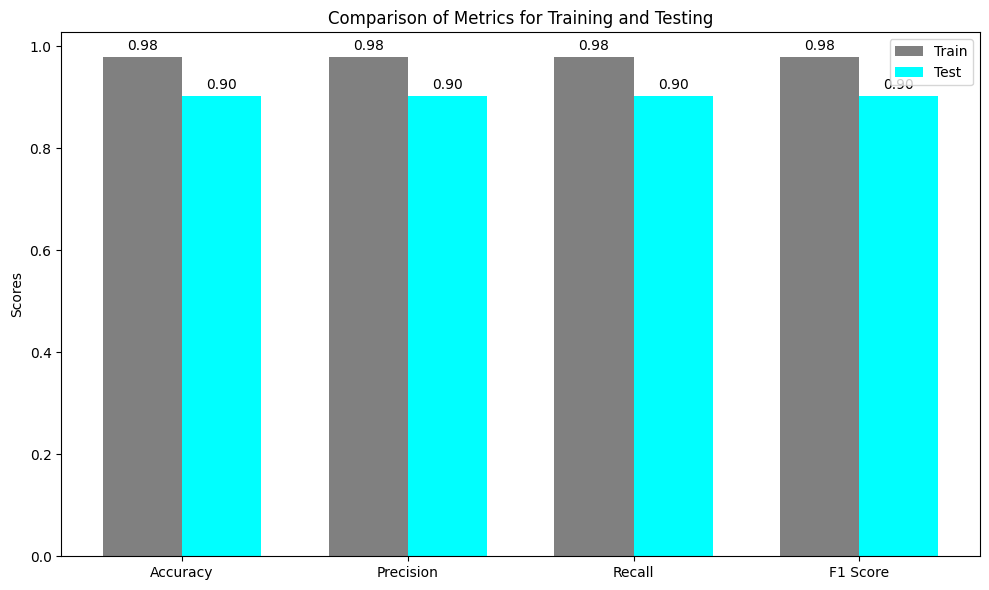

In [ ]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='grey')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='cyan')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities and binary classes
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification Report
print(classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.9022 - loss: 0.3221
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1016
           1       0.89      0.91      0.90       987

    accuracy                           0.90      2003
   macro avg       0.90      0.90      0.90      2003
weighted avg       0.90      0.90      0.90      2003



63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step


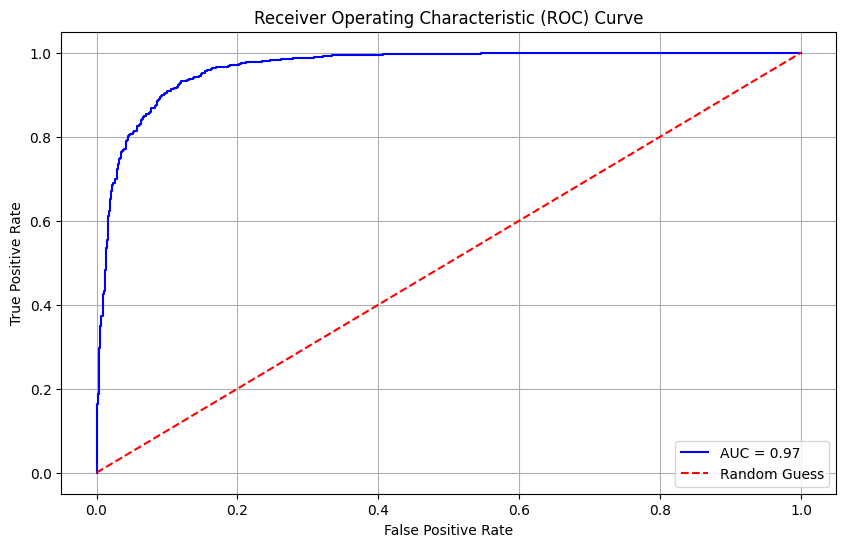

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).flatten()

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the AUC-ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 261ms/step


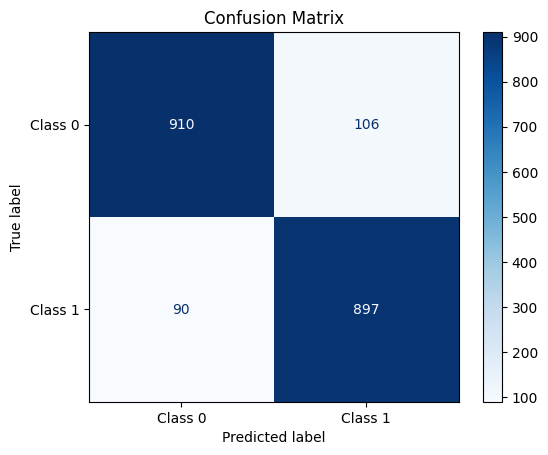

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

**EFFICIENT NET + CLASSIFIERS**

**EFFICIENT NET+SVC**

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step
Test Accuracy: 69.00%

Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1016
           1       0.65      0.81      0.72       987

    accuracy                           0.69      2003
   macro avg       0.70      0.69      0.69      2003
weighted avg       0.70      0.69      0.69      2003


Confusion Matrix:

[[584 432]
 [189 798]]


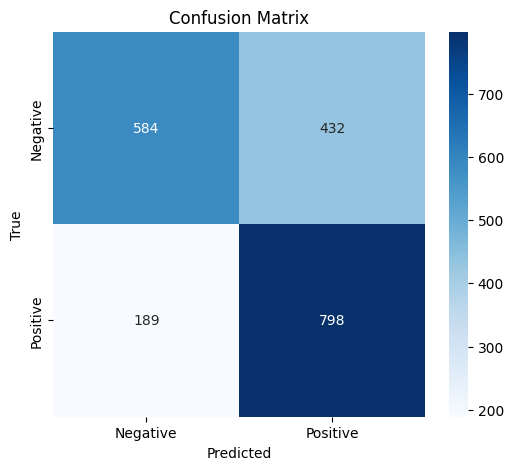

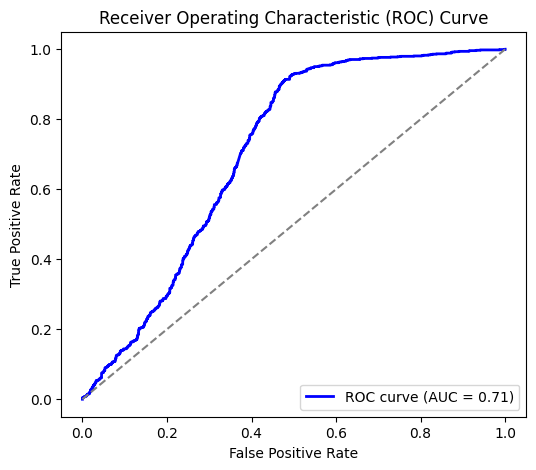

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for EfficientNet input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match EfficientNetB0 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained EfficientNetB0 model (exclude top layers)
input_shape = (64, 64, 3)
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_effnet.layers:
    layer.trainable = False

# Extract features using EfficientNetB0
effnet_model = Model(inputs=base_effnet.input, outputs=GlobalAveragePooling2D()(base_effnet.output))
X_train_features = effnet_model.predict(X_train)
X_test_features = effnet_model.predict(X_test)

# Train an SVC classifier
svc_classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svc_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = svc_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = svc_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**EFFICIENT NET+RANDOM FOREST**

251/251 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
Test Accuracy: 79.38%

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1016
           1       0.76      0.86      0.80       987

    accuracy                           0.79      2003
   macro avg       0.80      0.79      0.79      2003
weighted avg       0.80      0.79      0.79      2003


Confusion Matrix:

[[745 271]
 [142 845]]


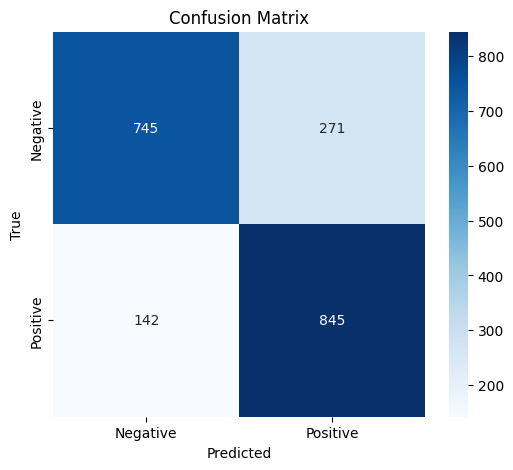

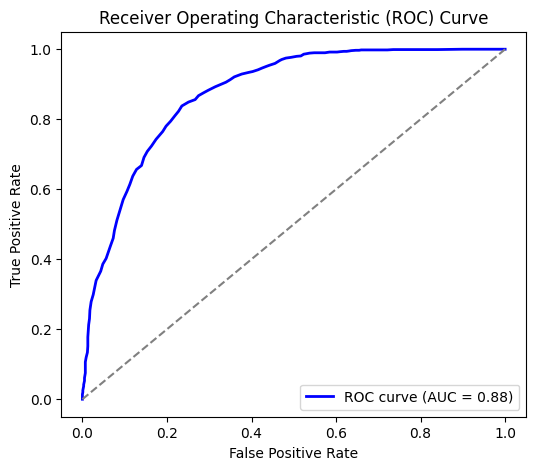

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for EfficientNet input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match EfficientNetB0 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained EfficientNetB0 model (exclude top layers)
input_shape = (64, 64, 3)
base_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_effnet.layers:
    layer.trainable = False

# Extract features using EfficientNetB0
effnet_model = Model(inputs=base_effnet.input, outputs=GlobalAveragePooling2D()(base_effnet.output))
X_train_features = effnet_model.predict(X_train)
X_test_features = effnet_model.predict(X_test)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = rf_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**EFFICIENT NET+XG BOOST**

251/251 ━━━━━━━━━━━━━━━━━━━━ 53s 201ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:19:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 80.43%

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.75      0.79      1016
           1       0.77      0.86      0.81       987

    accuracy                           0.80      2003
   macro avg       0.81      0.81      0.80      2003
weighted avg       0.81      0.80      0.80      2003


Confusion Matrix:

[[760 256]
 [136 851]]


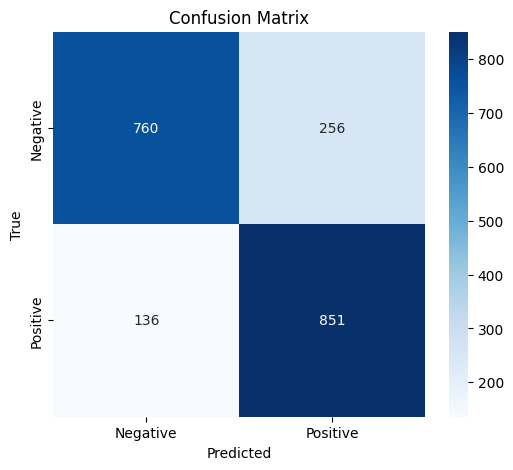

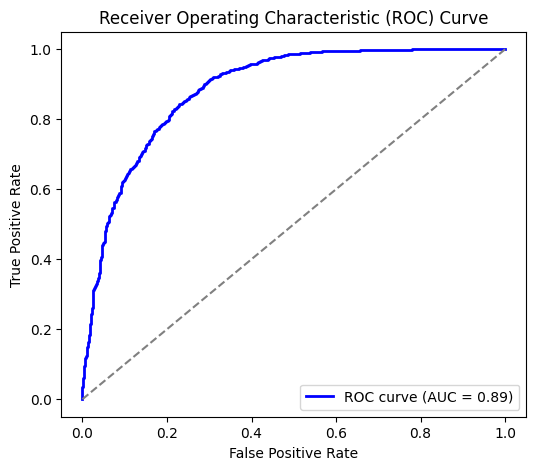

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for EfficientNetB0 input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match EfficientNetB0 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained EfficientNetB0 model (exclude top layers)
input_shape = (64, 64, 3)
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_efficientnet.layers:
    layer.trainable = False

# Extract features using EfficientNetB0
efficientnet_model = Model(inputs=base_efficientnet.input, outputs=GlobalAveragePooling2D()(base_efficientnet.output))
X_train_features = efficientnet_model.predict(X_train)
X_test_features = efficientnet_model.predict(X_test)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = xgb_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
